Nesse projeto foi realizado o reconhecimento de placa de carro com Tesseract, e o OpenCV, e uso do regex para extração de outras informações não necessárias presentes na placa.

O Tesseract é uma ferramenta de código aberto utilizada para realizar o reconhecimento de textos a partir de imagens.

In [90]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [91]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata

In [92]:
!mkdir tessdata

mkdir: cannot create directory ‘tessdata’: File exists


No github do tesseract foi selecionado a opção treinada em português: 

In [93]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true

--2022-11-30 13:58:10--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2022-11-30 13:58:10--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2022-11-30 13:58:10--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awa

In [116]:
import cv2
import pytesseract
import seaborn as sns

In [95]:
cv2.__version__

'4.6.0'

In [96]:
pytesseract.__version__

'0.3.10'

In [97]:
from google.colab.patches import cv2_imshow

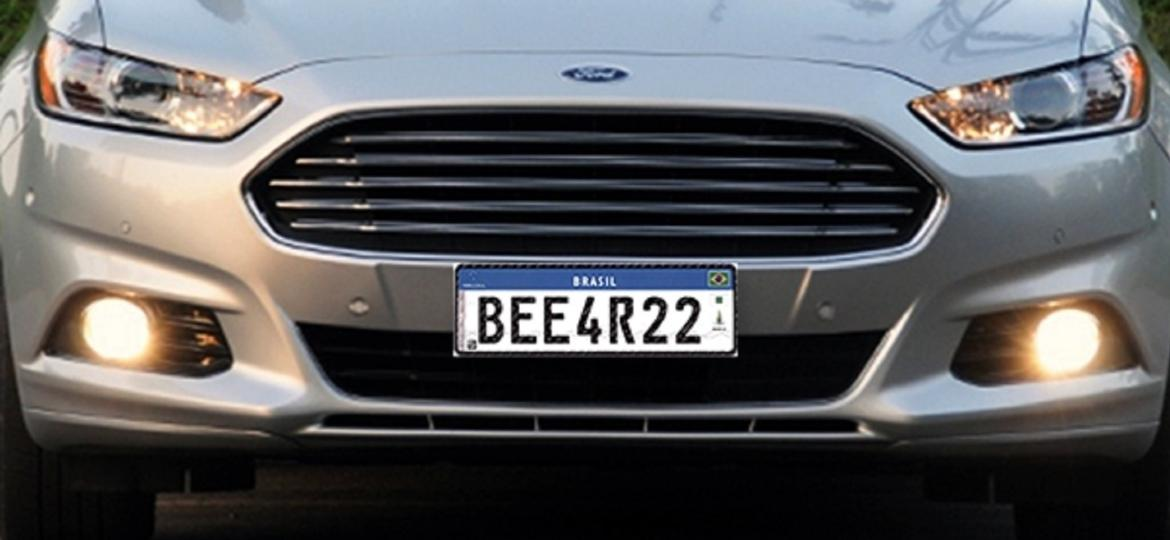

In [110]:
imagem =cv2.imread('/content/placa-carro.jpg')
cv2_imshow(imagem)

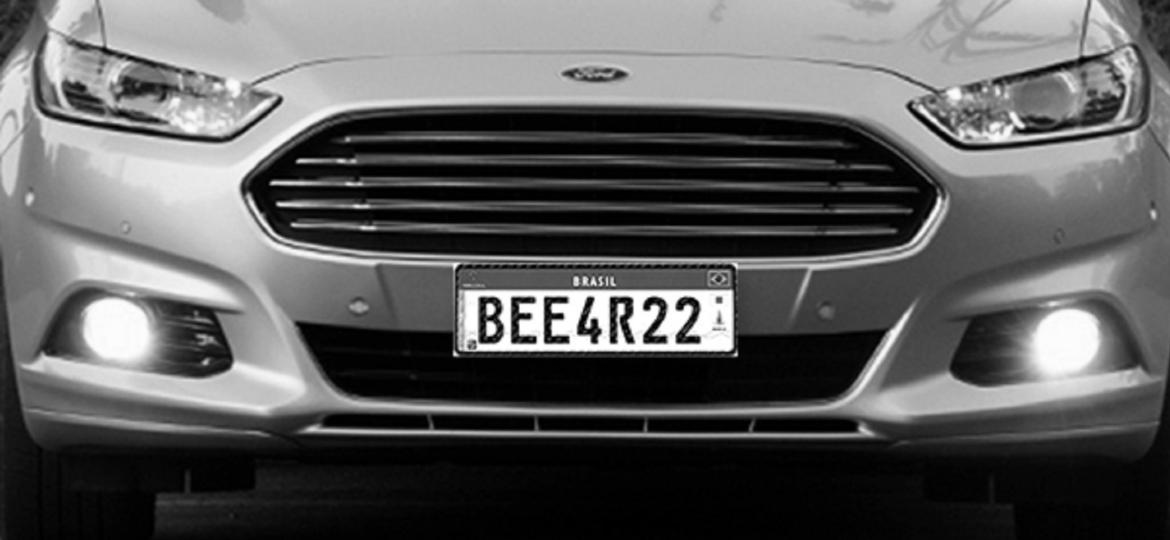

In [111]:
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
cv2_imshow(imagem)

In [112]:
config_tesseract = '--tessdata-dir tessdata'
texto = pytesseract.image_to_string(imagem, lang='por', config = config_tesseract)
print(texto)

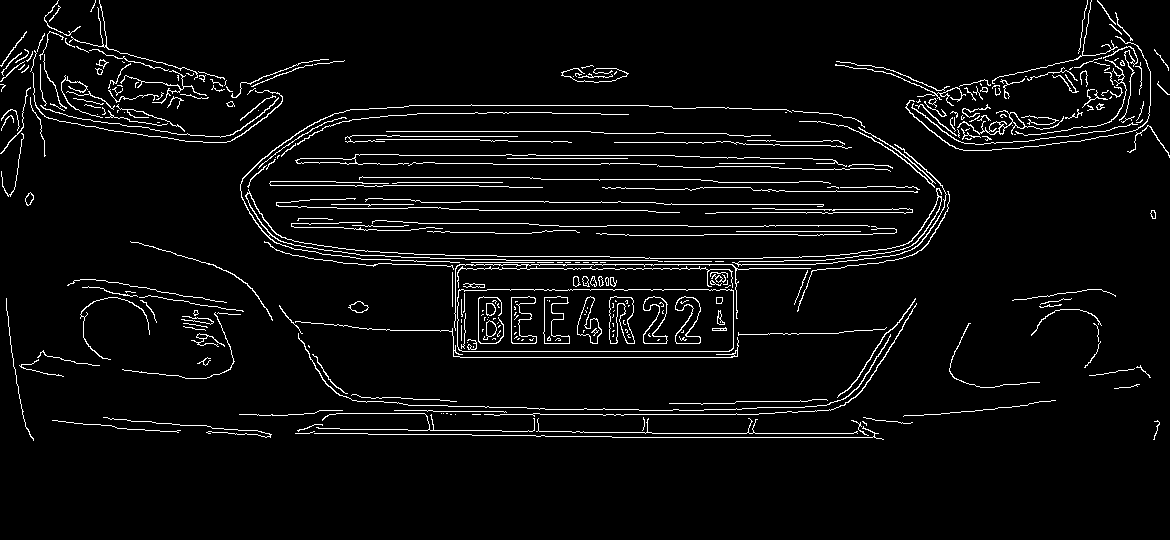

In [113]:
bordas= cv2.Canny(imagem, 100,200)
cv2_imshow(bordas)

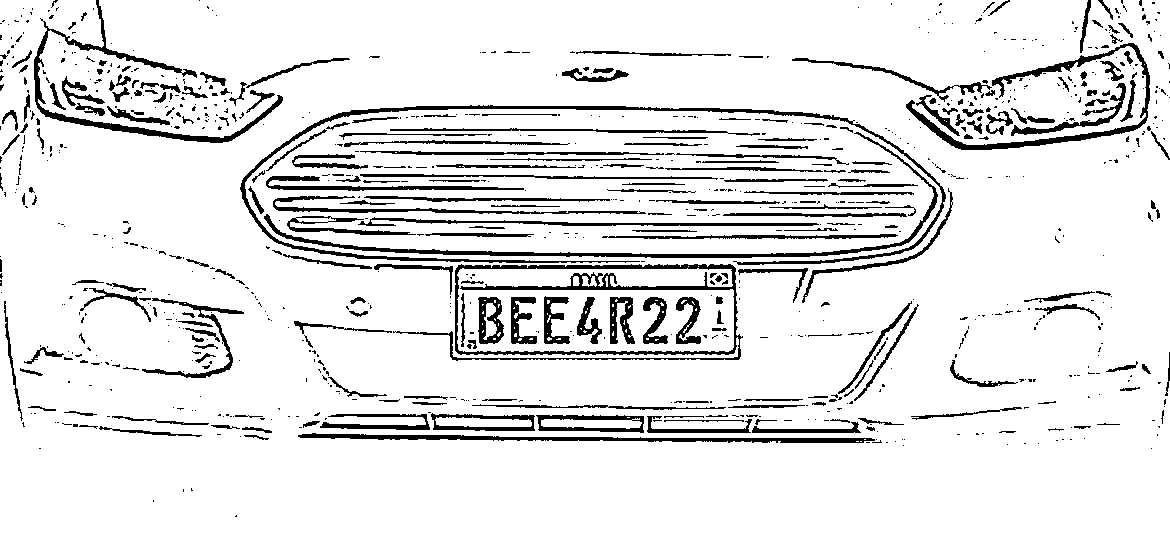

In [115]:
lim_adaptive = cv2.adaptiveThreshold(imagem, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 8)
cv2_imshow(lim_adaptive)

Fazendo um histograma para visualização dos picos de pixels entre 0 e 250, o limiar otsu vai encontrar o melhor valor entres esses picos do histograma, conforme apresentado abaixo:

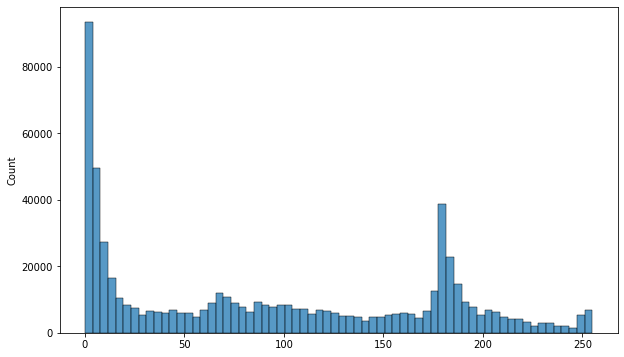

In [117]:
ax= sns.histplot(imagem.flatten())
ax.figure.set_size_inches(10,6)

Usando o Threshold para produzir um limiar binário(preto e brranco) e o limiar otsu

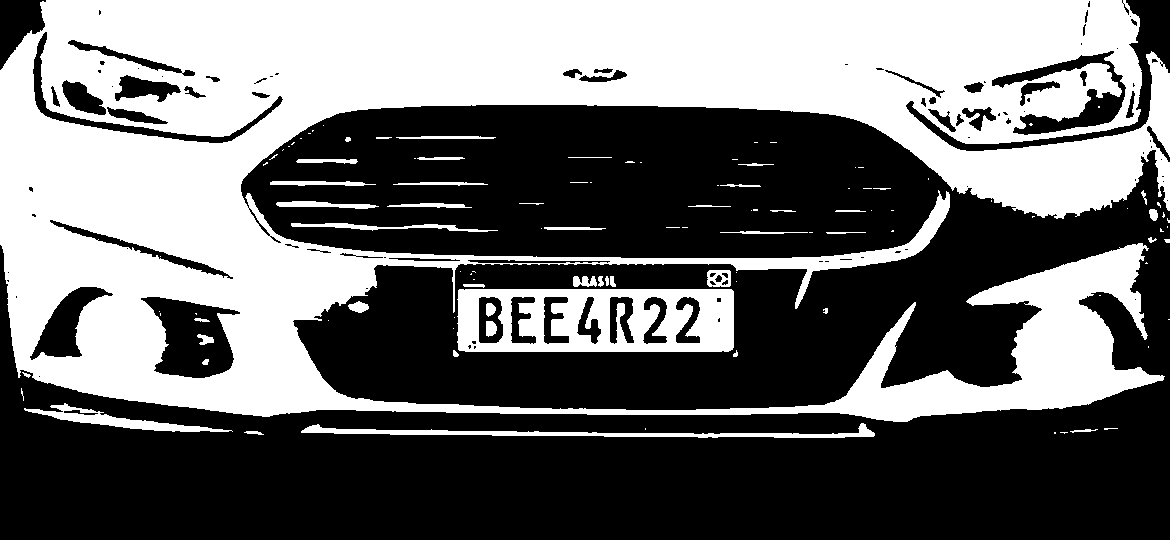

Limiar: 103.0


In [118]:
valor, lim_otsu = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2_imshow(lim_otsu)
print(f'Limiar: {valor}')

para esse caso o limiar otsu = 103

Aplicando o Canny para destacar as bordas

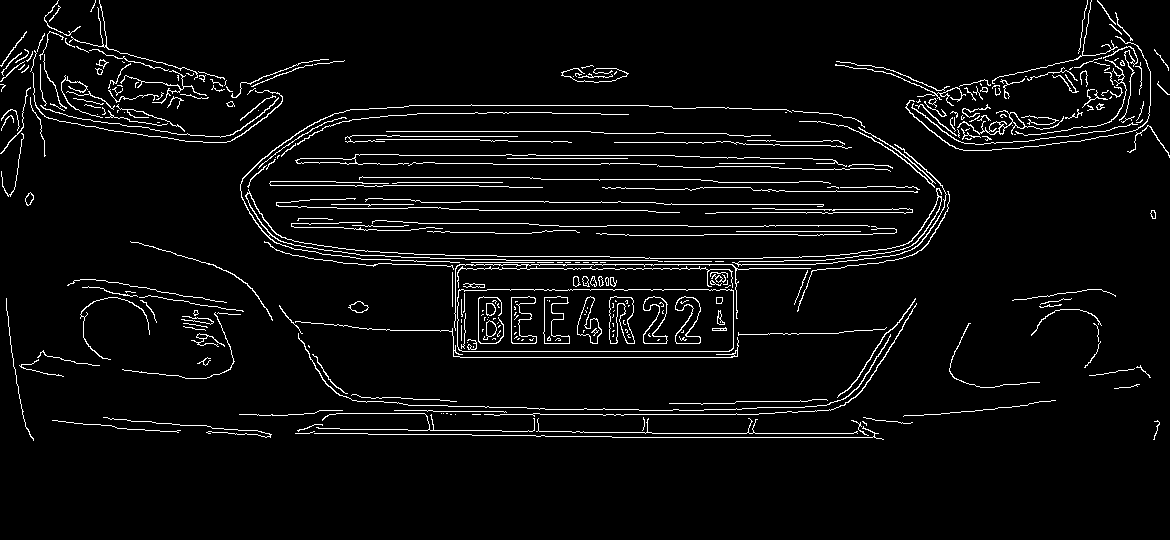

In [120]:
bordas = cv2.Canny(imagem,100,200)
cv2_imshow(bordas)

Selecionando os 10 contornos maiores em ordem de tamanho de área

In [133]:
contornos, hierarquia = cv2.findContours(bordas, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contornos = sorted(contornos, key = cv2.contourArea, reverse = True)[:10]

In [134]:
contornos

[array([[[459, 289]],
 
        [[458, 290]],
 
        [[458, 296]],
 
        [[457, 297]],
 
        [[457, 301]],
 
        [[458, 302]],
 
        [[458, 305]],
 
        [[457, 306]],
 
        [[457, 318]],
 
        [[458, 319]],
 
        [[458, 320]],
 
        [[457, 321]],
 
        [[457, 346]],
 
        [[458, 347]],
 
        [[458, 349]],
 
        [[459, 350]],
 
        [[461, 350]],
 
        [[462, 351]],
 
        [[729, 351]],
 
        [[730, 350]],
 
        [[731, 350]],
 
        [[733, 348]],
 
        [[733, 290]],
 
        [[732, 290]],
 
        [[731, 289]],
 
        [[730, 290]],
 
        [[729, 289]],
 
        [[728, 289]],
 
        [[727, 290]],
 
        [[726, 290]],
 
        [[725, 289]],
 
        [[720, 289]],
 
        [[719, 290]],
 
        [[716, 290]],
 
        [[715, 289]],
 
        [[713, 289]],
 
        [[712, 290]],
 
        [[711, 289]],
 
        [[710, 290]],
 
        [[709, 290]],
 
        [[708, 289]],
 
        [[688, 2

Aplicando uum função para perímetro, polígono com tamanho =4 (retângulo), com contorno convexo

In [135]:
for contorno in contornos:
        epsilon = 0.02 * cv2.arcLength(contorno, True)
        aproximacao = cv2.approxPolyDP(contorno, epsilon, True)
        if cv2.isContourConvex(aproximacao) and len(aproximacao) == 4:
          localizacao = aproximacao
          break

In [136]:
localizacao

array([[[458, 290]],

       [[462, 351]],

       [[733, 348]],

       [[731, 289]]], dtype=int32)

localizando os pontos das placas

In [137]:
x, y, w, h = cv2.boundingRect(localizacao)

In [138]:
x

458

In [139]:
h

63

In [140]:
y

289

In [141]:
w

276

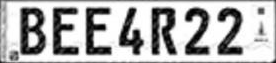

In [142]:
placa = imagem[y:y+h, x:x+w]
cv2_imshow(placa)

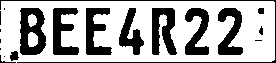

In [143]:
valor, lim_otsu = cv2.threshold(placa, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2_imshow(lim_otsu)

Utilizando o pytesseract para localização das letras da placa

In [144]:
config_tesseract = '--tessdata-dir tessdata --psm 6'
texto = pytesseract.image_to_string(lim_otsu, lang='por', config = config_tesseract)
print(texto)

BEE4R22:



importando regex para aplicar a eliminação de caracteres que não fazem parte do número da placa, como o BR por exemplo.

In [146]:
import re

In [149]:
texto_extraido = re.search('\w{3}\d{1}\w{1}\d{2}', texto)
texto_extraido

<re.Match object; span=(0, 7), match='BEE4R22'>

#Identificação da placa

In [150]:
print(texto_extraido.group(0))

BEE4R22
